# Problem Set 1: Eigenfaces and Face reconstruction

AI 211 | 2nd Sem AY 2023-2024

Students:  
Joshua Cantor  
Michael Spencer Quinto


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import math

from sklearn.metrics import r2_score, mean_squared_error

## Eigenfaces and Face reconstruction

Load faces.mat. This contains the matrix X with 5000 rows and 1024 columns. The columns are
the rolled-out 32x32 pixel values of a face image. Try to reshape one row data into 32x32 matrix
and plot the image using a grayscale colormap. The first 100 faces are shown below.


In [2]:
mat_contents = scipy.io.loadmat("../raw-data/faces.mat")
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [3]:
faces = mat_contents["X"]

In [6]:
def print_face(matrix):
    plt.rcParams["figure.figsize"] = [5, 5]
    plt.rcParams.update({"font.size": 8})
    plt.rcParams["figure.constrained_layout.use"] = True

    img = plt.imshow(matrix)
    img.set_cmap("gray")
    plt.axis("off")
    plt.show()

In [76]:
def print_faces(faces, N=100, column_size=10):
    w = faces.shape[1]
    n = m = int(math.sqrt(w))
    row_size = int(N / column_size)
    count = 0
    allPersons = np.zeros((n * row_size, m * column_size))
    while count < N:
        for i in range(row_size):
            for j in range(column_size):
                allPersons[i * n : (i + 1) * n, j * m : (j + 1) * m] = np.real(
                    faces[count, :].reshape(n, m).T
                )
                count += 1

    plt.rcParams["figure.figsize"] = [5, 5]
    plt.rcParams.update({"font.size": 8})
    plt.rcParams["figure.constrained_layout.use"] = True

    img = plt.imshow(allPersons)
    img.set_cmap("gray")
    plt.axis("off")
    plt.show()

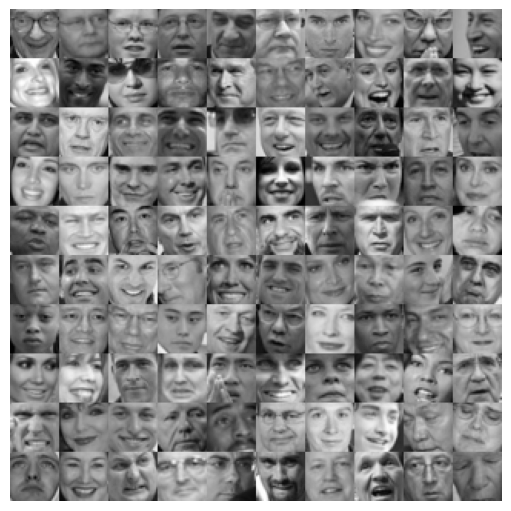

In [8]:
print_faces(faces, N=100)

### SVD on X

Perform SVD on X, identify the eigenfaces and plot the first few of them. Note that these
eigenvectors correspond to eigenvalues with large values which together explains most of the
variation in the data.


In [9]:
# I'll be using 70-30 split
faces_70 = int(faces.shape[0] * 0.7)
indices = np.random.permutation(faces.shape[0])
training_idx, test_idx = indices[:faces_70], indices[faces_70:]
training_faces, test_faces = faces[training_idx, :], faces[test_idx, :]

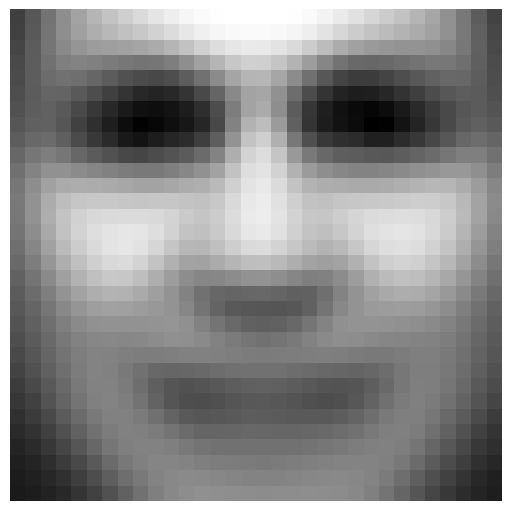

In [10]:
average_face = np.mean(training_faces, axis=0)
print_face(np.reshape(average_face, (32, 32)).T)

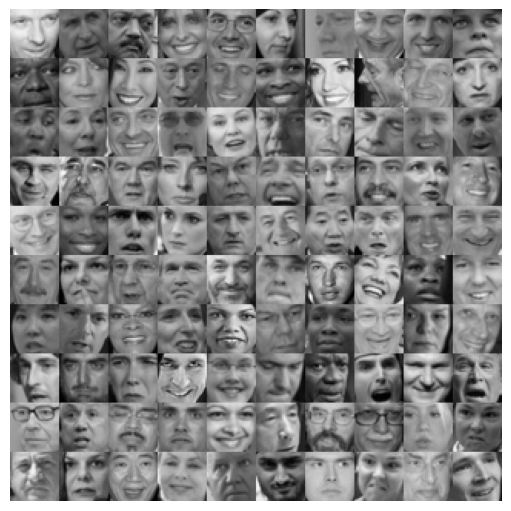

In [11]:
X = training_faces
print_faces(X, N=100)

In [12]:
def sv_decomposition(matrix, reduced_svd=False):
    m, n = matrix.shape
    if reduced_svd:
        s = min(m, n)
    else:
        s = max(m, n)

    # Compute for ATA
    ATA = np.dot(matrix.T, matrix)

    # Compute for Eigenvalues and Eigenvectors
    eigenvalues_ATA, V = np.linalg.eig(ATA)

    # Apply dimensionality reduction
    eigenvalues_ATA = eigenvalues_ATA[:s]
    V = V[:, :s]

    # Sort Eigenvalues and V by eigenvalues in descending order
    sort_desc = np.argsort(eigenvalues_ATA)[::-1]

    eigenvalues_ATA = eigenvalues_ATA[sort_desc]
    V = V[:, sort_desc]

    # Square root of eigenvalues, is Sigma
    S = np.diag(np.sqrt(eigenvalues_ATA))
    S_inv = np.linalg.inv(S)

    # Compute U as U = AVS^-1.
    U = np.dot(matrix, np.dot(V, S_inv))

    return U, S, V.T

In [13]:
# Perform SVD
U, S, VT = sv_decomposition(X.T)

### a. Observe what features are represented by the first few eigenfaces.


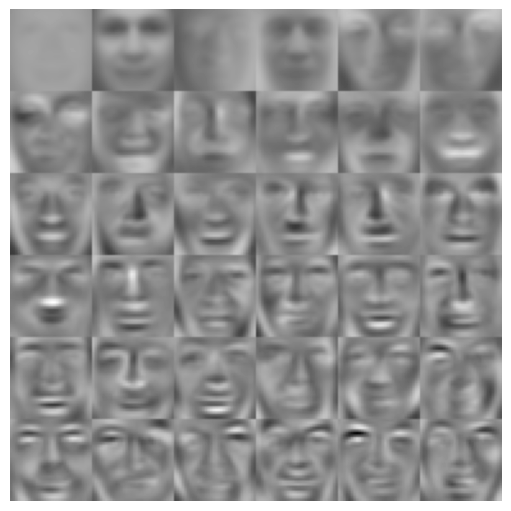

In [14]:
print_faces(U.T, N=36, column_size=6)

For the first pictures presented by eigenfaces:

- First Eigenface: Represents the overall average lighting and shadow patterns in the faces.
- Second Eigenface: Captures variations in the overall horizontal features of the faces, such as the position of the eyes and width of the face.
- Third Eigenface: Highlights the vertical features, such as the position of the mouth and height of the face.
- Subsequent Eigenfaces: Capture more localized features such as the presence and shape of facial features (e.g., nose, mouth, eyes) and other finer details.


# ======================================================


### b. Discuss how dimensionality reduction is performed and what is the rationale of doing dimensionality reduction.

Dimensionality Reduction was performed using the min(m,n). There are many ways on dimensionality reduction, namely:

- Principal Component Analysis (PCA)
- Linear Discriminant Analysis (LDA)
- Generalized Discriminant Analysis (GDA)

But, in our approach, we will just focusing on removing (not completely) the null space on our SVD.

The graph shown below is the logarithmic plot of the Sigma:


C:\Users\Jouh\AppData\Local\Temp\ipykernel_27700\2823503277.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.real(np.diag(S))))


Text(0, 0.5, 'log singular values')

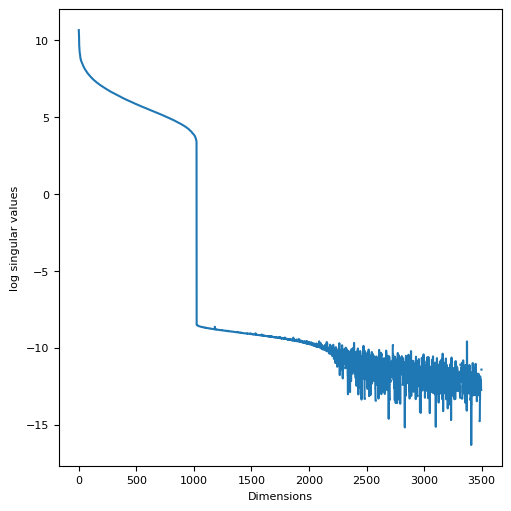

In [15]:
# Plot of our Singular Values after Dimensionality Reduction:
plt.rcParams.update({"font.size": 8})
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(np.log(np.real(np.diag(S))))
plt.xlabel("Dimensions")
plt.ylabel("log singular values")

Warnings from plotting the values came from the "np.nan". As you can see the graph has so much noise. We can also see that starting below 4, its starting to drop and we can see that the graph does not make sense.

We can fix it using a dimensionality reduction. Thus, resulted in a cleaner graph:


Text(0, 0.5, 'log singular values')

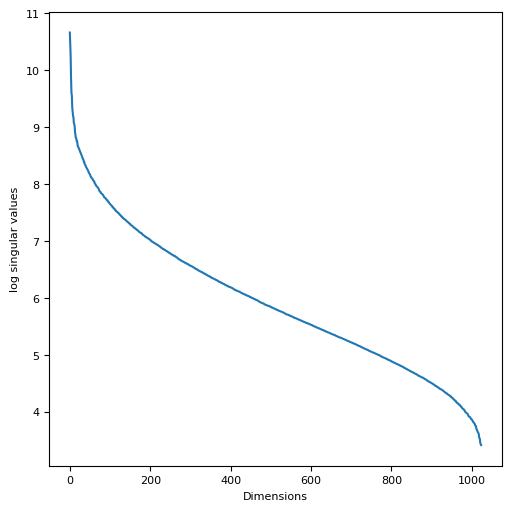

In [72]:
# Perform SVD
U, S, VT = sv_decomposition(X.T, reduced_svd=True)

# Plot of our Singular Values after Dimensionality Reduction:
plt.rcParams.update({"font.size": 8})
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(np.log(np.diag(S)))
plt.xlabel("Dimensions")
plt.ylabel("log singular values")

The rationale in doing the dimensionality reduction is "economical" since it reduces the memory/storage of the matrix. Furthermore,

- Noise Reduction: Reduces the impact of noise in the data by focusing on the components with the most significant values.
- Computational Efficiency: Reduces the computational cost and storage requirements by lowering the number of features.
- Data Visualization: Simplifies the visualization of high-dimensional data by reducing it to two or three dimensions.
- Improved Performance: Can improve the performance of machine learning algorithms by eliminating redundant and less informative features.


### c. Discuss how compression is achieved using SVD.


The singular vectors and singular values are ordered in descending order. For this reason, using just the first few singular vectors and singular values will provide the reconstruction of the image. Moreover, by looking back to the logirithmic graph of Sigma, it shows that 1 to 100 dimensions has the biggest singular values.

Compression was acheived in SVD by limiting the first k components from maximum components. E.g. first 100 components out of 1024 components.


In [17]:
def compress_svd(U, S, VT, k):
    return U[:, :k] @ (np.diag(np.diag(S)[:k]) @ VT[:k, :])

Reconstruct the faces using the first k eigenfaces and compute the error of reconstruction averaged over all the faces.


Number of components =  10

        R^2 is 0.6709127380812856
        RMSE is 23.196290353973215
        NRMSE is 0.5230865827087199
    


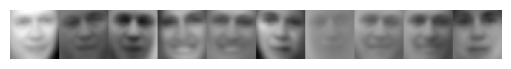

Number of components =  41

        R^2 is 0.8459729456284484
        RMSE is 15.792873746636934
        NRMSE is 0.35613627149927296
    


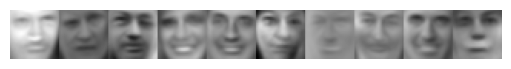

Number of components =  72

        R^2 is 0.904624675527999
        RMSE is 12.403997638177625
        NRMSE is 0.279715619931874
    


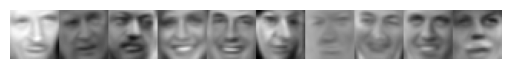

In [77]:
# Reconstructing using first 10 eigenfaces
for k in range(10, 101, 31):
    print("Number of components = ", k)
    reconstimg = compress_svd(U, S, VT, k)
    r2 = r2_score(X, np.real(reconstimg.T))
    rmse = math.sqrt(mean_squared_error(X, np.real(reconstimg.T)))

    # RMSE normalised by mean:
    nrmse = rmse / math.sqrt(np.mean(X**2))
    print(
        f"""
        R^2 is {r2}
        RMSE is {rmse}
        NRMSE is {nrmse}
    """
    )
    print_faces(reconstimg.T, N=10, column_size=10)

Plot the average reconstruction error versus k from 1 to 100.


In [82]:
# Reconstruction Error
error_record = []
for k in range(1, 101):
    reconstimg = compress_svd(U, S, VT, k)
    total_loss = np.linalg.norm((X - reconstimg.T), None)
    error_record.append(total_loss)

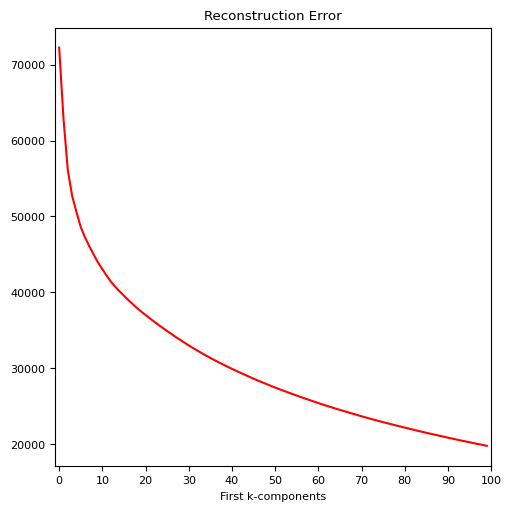

In [90]:
# Plot the Reconstruction Error
plt.title("Reconstruction Error")
plt.xlabel("First k-components")
plt.plot(error_record, "r")
plt.xticks(range(0, 101, 10))
plt.xlim([-1, len(error_record)])
plt.show()

### ==========================================================================================================

Other method


In [87]:
# Reconstructing using first 10 eigenfaces
rmse_scores, nrmse_scores, r2_scores = ([] for _ in range(3))
for k in range(1, 101):
    reconstimg = compress_svd(U, S, VT, k)
    r2 = r2_score(X, np.real(reconstimg.T))
    r2_scores.append(r2)
    rmse = math.sqrt(mean_squared_error(X, np.real(reconstimg.T)))
    rmse_scores.append(rmse)
    # RMSE normalised by mean:
    nrmse = rmse / math.sqrt(np.mean(X**2))
    nrmse_scores.append(nrmse)

C:\Users\Jouh\AppData\Local\Temp\ipykernel_27700\1181472289.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # to ensure the right y-label is not slightly clipped


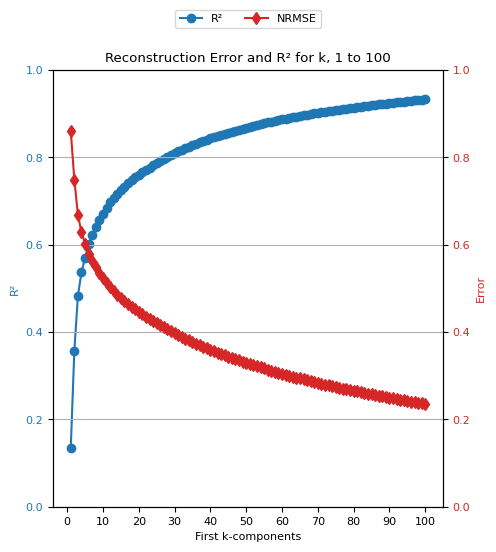

In [89]:
# Plotting
x = np.arange(1, 101)

fig, ax1 = plt.subplots()

# Plotting R² on the primary y-axis
ax1.set_xlabel("First k-components")
ax1.set_ylabel("R²", color="tab:blue")
ax1.plot(x, r2_scores, "o-", color="tab:blue", label="R²")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, 1)  # R² ranges from 0 to 1

# Creating a secondary y-axis to plot RMSE and NRMSE
ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="tab:red")
ax2.plot(x, nrmse_scores, "d-", color="tab:red", label="NRMSE")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(0, 1)  # NRMSE ranges from 0 to 1

# Adding legends
fig.tight_layout()  # to ensure the right y-label is not slightly clipped
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10), ncol=2)

# Adding title and grid
plt.title("Reconstruction Error and R² for k, 1 to 100")
plt.grid(True)
plt.xticks(range(0, 101, 10))

plt.show()